In [1]:
%run DataLoader.ipynb
%run Visualization.ipynb

from skimage.transform import resize
import numpy as np
from itertools import product
from collections import OrderedDict
import os
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import transforms, utils, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from thirdparty.Run import RunBuilder as RB
from thirdparty.Run import RunManager as RM

In [2]:
torch.set_printoptions(linewidth=120) 
device = torch.device("cuda:0")

# Model Definition

In [3]:
# Model definition and model loading

import torch
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F

class TLearning(nn.Module):
    def __init__(self):
        super(TLearning,self).__init__()
        self.ResNet = models.resnet50(pretrained=True, progress=True)
        
        self.fc1 = nn.Linear(in_features =1000, out_features = 512, bias=True)
        self.fc2 = nn.Linear(in_features = 512, out_features = 256, bias=True)
        self.fc3 = nn.Linear(in_features = 256, out_features = 64, bias=True)
        self.fc4 = nn.Linear(in_features = 64, out_features = 1, bias=True)
    def forward(self, Input):
        image = self.ResNet(Input)
        # input size = (1,3,224,224)-(Batches, Channels, Height, Width)
        # output size = (1, 1000)-(Batches, Feature)
        image = F.relu(self.fc1(image))
        # input size = (1,1000)-(batches, features)
        # output size = (1,512)-(batches, features)
        image = F.relu(self.fc2(image))
        # input size = (1,512)-(batches, features)
        # output size = (1,256)-(batches, features)
        image = F.relu(self.fc3(image))
        # input size = (1,256)-(batches, features)
        # output size = (1,64)-(batches, features)
        image = self.fc4(image)
        # input size = (1,64)-(batches, features
        # output size = (1,1)-(batches, features)
        return image

# Model Training / Loading

In [ ]:
parameters = OrderedDict(
    learning_rate = [0.001],
    batch_size = [50],
    num_workers = [1],
    #shuffle = [True,False]
)
m = RM.RunManager()
for run in RB.RunBuilder.get_runs(parameters):
    network = TLearning()
    network.cuda()
    network.to(device)
    optimizer = optim.Adam(network.parameters(),lr = run.learning_rate,betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001/run.batch_size, amsgrad=False)
# modify the time to visible time format, also use it to check the sequency of pictures is from former to current
    udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                     root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera='center_camera')
    dataset_size = int(len(udacity_dataset))
    del udacity_dataset
    split_point = int(dataset_size * 0.8)

    training_set = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                     root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera='center_camera',
                                     select_range=(0,split_point))

    validation_set = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                     root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                     transform=transforms.Compose([transforms.ToTensor()]),
                                     select_camera='center_camera',
                                     select_range=(split_point,dataset_size))
    print("size of training set :{}".format(len(training_set)))
    print("size of validation set :{}".format(len(validation_set)))
    
    training_cbs = ConsecutiveBatchSampler(data_source=training_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=1)
    training_loader = DataLoader(training_set, sampler=training_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))

    validation_cbs = ConsecutiveBatchSampler(data_source=validation_set, batch_size=run.batch_size, shuffle=True, drop_last=False, seq_len=1)
    validation_loader = DataLoader(validation_set, sampler=validation_cbs, num_workers=run.num_workers, collate_fn=(lambda x: x[0]))

    m.begin_run( run,network,[run.batch_size,3,224,224] )
    for epoch in range(10):
        m.begin_epoch()
        for training_sample in tqdm(training_loader):
            training_sample['image'] = training_sample['image'].squeeze()
            training_sample['image'] = torch.Tensor(resize(training_sample['image'], (run.batch_size,3,224,224),anti_aliasing=True))

            param_values = [v for v in training_sample.values()]
            image,angle = param_values[0],param_values[3]
            image = image.to(device)
            prediction = network(image)
            prediction = prediction.to(device)
            labels = angle.to(device)
            del param_values, image, angle
            if labels.shape[0]!=prediction.shape[0]:
                prediction = prediction[-labels.shape[0],:]
            training_loss_angle = F.mse_loss(prediction,labels,size_average=None, reduce=None, reduction='mean')
            optimizer.zero_grad()# zero the gradient that are being held in the Grad attribute of the weights
            training_loss_angle.backward() # calculate the gradients
            optimizer.step() # finishing calculation on gradient 
        print("Done")
# Calculation on Validation Loss
        with torch.no_grad():    
            for Validation_sample in tqdm(validation_loader):
                Validation_sample['image'] = Validation_sample['image'].squeeze()
                Validation_sample['image'] = torch.Tensor(resize(Validation_sample['image'], (run.batch_size,3,224,224),anti_aliasing=True))

                param_values = [v for v in Validation_sample.values()]
                image,angle = param_values[0],param_values[3]
                image = image.to(device)
                prediction = network(image)
                prediction = prediction.to(device)
                labels = angle.to(device)
                del param_values, image, angle
                if labels.shape[0]!=prediction.shape[0]:
                    prediction = prediction[-labels.shape[0],:]
                validation_loss_angle = F.mse_loss(prediction,labels,size_average=None, reduce=None, reduction='mean')
                m.track_loss(validation_loss_angle)
                m.track_num_correct(prediction,labels) 
        m.end_epoch(validation_set)
        torch.save(network.state_dict(), "/export/jupyterlab/lintao/TransferLearning/Done/Angle_Adam_MSE_Non5000_Paper_Model/Angle_Adam_MSE_Paper_Model-epoch-{}".format(epoch))
    m.end_run()
m.save('result')

size of training set :27046
size of validation set :6762


In [4]:
# Load Directly from disk

tl_model = TLearning().to(device)
tl_model.load_state_dict(torch.load('saved_models/TransferLearning/Angle_Adam_MSE_Paper_Model-epoch-4'))

<All keys matched successfully>

# Visualization

(64, 3, 7, 7)


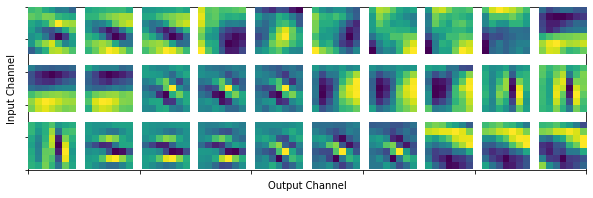

In [6]:
visualize_cnn(tl_model.ResNet.conv1)

### GradCAM

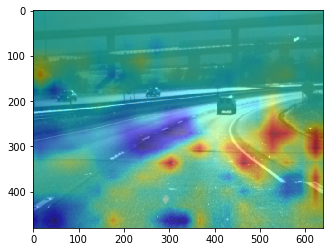

In [9]:
udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                 root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera')


# Load arbitrary data
sample = udacity_dataset[3693]
show_sample(sample)
input_image = sample['image'].reshape(-1, 3, 480, 640).cuda()

cam_extractor_tl = CamExtractorTLModel(tl_model)

# Forward pass
model_output = tl_model(input_image)

# Backward pass
tl_model.zero_grad()
mse_loss = nn.MSELoss()
loss = mse_loss(model_output, sample['angle'].cuda().reshape(1,1))
loss.backward()

cam_image = cam_extractor_tl.to_image(height=480, width=640) # Use this line to extract CAM image from the model!
plt.imshow(cam_image[0, :, :], cmap='jet', alpha=0.5) # this shows CAM as overlay to the original input image


In [6]:
cam_extractor_tl = CamExtractorTLModel(tl_model)

batch_size = 5
udacity_dataset = UdacityDataset(csv_file='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/interpolated.csv',
                                 root_dir='/export/jupyterlab/data/udacity-challenge-2/Ch2_002_export/',
                                 transform=transforms.Compose([transforms.ToTensor()]),
                                 select_camera='center_camera')

# 3D CNN has different input batch size and seq_len, so we define new CBS and Loader
cbs = ConsecutiveBatchSampler(data_source=udacity_dataset, batch_size=batch_size, shuffle=False, drop_last=False, seq_len=1, use_all_frames=True)
loader = DataLoader(udacity_dataset, sampler=cbs, collate_fn=(lambda x: x[0]))

In [ ]:
mse_loss = nn.MSELoss()

angle_pred_history = []
angle_true_history = []

frame_count = 0
for i, testing_sample in enumerate(tqdm(loader, total=len(loader))):
    image_input = testing_sample['image'].squeeze().to(device)
    prediction = tl_model(image_input).squeeze()
    target = testing_sample['angle'].squeeze().to(device)
    loss = mse_loss(prediction, target)
    loss.backward()
    
    cam_image = cam_extractor_tl.to_image(width=640, height=480) # Use this line to extract CAM image from the model!
    tl_model.zero_grad()
    
    for b in range(batch_size):
        fig, ax = plt.subplots()
        show_image_single(ax, testing_sample['image'][b, 0, :, :, :].permute(1, 2, 0),
                          cam_image=cam_image[b, :, :],
                          angle_pred=prediction[b].cpu().detach().numpy()*30,
                          speed=testing_sample['speed'][b].detach().numpy(),
                          angle_true=float(testing_sample['angle'][b].detach().numpy())*30)
        
        angle_pred_history.append(float(prediction[b].cpu().detach().numpy()))
        angle_true_history.append(float(testing_sample['angle'][b].detach().numpy()))
    
        plt.savefig("validation_images/tl-all-{}".format(frame_count))
        frame_count += 1
        plt.close()
        
    del cam_image, image_input
    
fig, ax = plt.subplots()
ax.plot(angle_pred_history, color='red', label='predicted')
ax.plot(angle_true_history, color='blue', label='true')
ax.legend()